In [10]:
# import packages for doing time series classification form .csv files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import math
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim


device = 'mps'

In [2]:
# load the data (there is no header)

data_train = pd.read_csv(
    "/Users/lorenzotarricone/Desktop/ETH/2nd_semester/Machine Learning For Healthcare/Project_2_general/project2_TS_input/ptbdb_train.csv",
    header=None,
)

# the last column is the label
y_train = data_train[187].astype(int)


# the data is the rest
X_train = data_train.iloc[:, 0:187]

# load the test data
data_test = pd.read_csv(
    "/Users/lorenzotarricone/Desktop/ETH/2nd_semester/Machine Learning For Healthcare/Project_2_general/project2_TS_input/ptbdb_test.csv",
    header=None,
)

# the last column is the label
y_test = data_test[187].astype(int)

# the data is the rest
X_test = data_test.iloc[:, 0:187]

#Get the percentage of class 1 and 0 in the training set
print("Percentage of class 1 in the training set: ", y_train.sum()/len(y_train))
print("Percentage of class 0 in the training set: ", 1-y_train.sum()/len(y_train))

Percentage of class 1 in the training set:  0.7219311055751224
Percentage of class 0 in the training set:  0.2780688944248776


In [3]:



class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


# Calculate class imbalance
def calculate_class_weights(labels, printa=False):
    class_0_number, class_1_number = torch.bincount(labels.long())
    if printa:
        print("Class 0 counts: ", class_0_number)
        print("Class 1 counts: ", class_1_number)

    weight = class_0_number / class_1_number
    if printa:
        print("Class 0 weight: ", 1)
        print("Class 1 weight: ", weight)

    return weight


# create a dataloader
train_data = Dataset(
    torch.tensor(X_train.values).float(), torch.tensor(y_train.values).float()
)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = Dataset(
    torch.tensor(X_test.values).float(), torch.tensor(y_test.values).float()
)
test_loader = DataLoader(test_data, batch_size=2911, shuffle=False)

----------
## Transformer

In [7]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding for the Transformer model

    Args:
        d_model: int, the number of expected features in the input
        dropout: float, the dropout value
        max_len: int, the maximum length of the input sequence

    Attributes:
        dropout: nn.Dropout, the dropout layer
        pe: torch.Tensor, the positional encoding values
    """

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super(CustomTransformerEncoderLayer, self).__init__(*args, **kwargs)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2, attn_weights = self.self_attn(
            src, src, src, attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,

        )
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src, attn_weights

class TransformerModel(nn.Module):
    """
    Transformer model for time series classification

    Args:
        input_dim: int, the number of expected features in the input
        n_head: int, the number of heads in the multiheadattention models
        hidden_dim: int, the dimension of the feedforward network model
        num_layers: int, the number of sub-encoder-layers in the encoder
        output_dim: int, the number of expected features in the output
        dropout: float, the dropout value

    Attributes:
        embedding: nn.Linear, the linear layer for the input
        positional_encoding: PositionalEncoding, the positional encoding layer
        transformer_encoder: nn.TransformerEncoder, the transformer encoder layer
        fc: nn.Linear, the linear layer for the output
        attention_weights: list, the attention weights for each layer

    """
    def __init__(self, input_dim, n_head, hidden_dim, num_layers, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim)

        encoder_layers = CustomTransformerEncoderLayer(
            hidden_dim, nhead=n_head, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers, num_layers=num_layers
        )

        self.fc = nn.Linear(hidden_dim * 187, output_dim)
        self.attention_weights = []

    def forward(self, src):
        src = src.unsqueeze(2)
        src = self.embedding(src)
        src = self.positional_encoding(src)
        output = src
        self.attention_weights = []
        for layer in self.transformer_encoder.layers:
            output, attn_weights = layer(output)
            self.attention_weights.append(attn_weights)
        output = output.reshape(output.size(0), -1)
        output = self.fc(output)
        return output
    
    def training_func(self, train_loader, optimizer, criterion, epochs=10):
        print("######### MODEL TRAINING #########")
        for epoch in range(epochs):
            total_loss = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = self(data)
                target = target.unsqueeze(1)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(
                "Epoch: {}, Average Training Loss: {:.4f}".format(
                    epoch + 1, total_loss / len(train_loader)
                )
            )
        print("\n")

    def evaluate_model(self, test_loader, threshold=0.5, plot_confusion_matrix=False):
        print("########### MODEL EVALUATION ###########")
        self.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for sequence, labels in test_loader:
                sequence = sequence.to(device)
                labels = labels.to(device)
                outputs = self(sequence)
                predicted = (outputs > threshold).float()
                total += labels.size(0)
                correct += (predicted == labels.view(-1, 1)).sum().item()

            print(
                "Accuracy of the model on the test set: {} %".format(
                    100 * correct / total
                )
            )

            if plot_confusion_matrix:
                y_true = labels.cpu().numpy()
                y_pred = predicted.cpu().numpy()
                print("Confusion matrix: \n\n", confusion_matrix(y_true, y_pred))

    def get_attention_maps(self):
        return self.attention_weights

# Define the model
input_dim = 1  # Input dimensionality
output_dim = 1  # Binary classification
n_head = 4
hidden_dim = 100
num_layers = 2
dropout = 0.1
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(input_dim, n_head, hidden_dim, num_layers, output_dim, dropout).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Train the model
model.training_func(train_loader, optimizer, criterion, num_epochs)

# Evaluate the model
model.evaluate_model(test_loader, plot_confusion_matrix=True)

# Plot the attention map for the first layer and first head


######### MODEL TRAINING #########
Epoch: 1, Average Training Loss: 0.5748
Epoch: 2, Average Training Loss: 0.4280
Epoch: 3, Average Training Loss: 0.3826
Epoch: 4, Average Training Loss: 0.3422
Epoch: 5, Average Training Loss: 0.3194
Epoch: 6, Average Training Loss: 0.3163
Epoch: 7, Average Training Loss: 0.3059
Epoch: 8, Average Training Loss: 0.2847
Epoch: 9, Average Training Loss: 0.2534
Epoch: 10, Average Training Loss: 0.2407


########### MODEL EVALUATION ###########
Accuracy of the model on the test set: 82.7894194434902 %
Confusion matrix: 

 [[ 497  312]
 [ 189 1913]]


shape of attention maps for each layer: [2911, 187, 187]


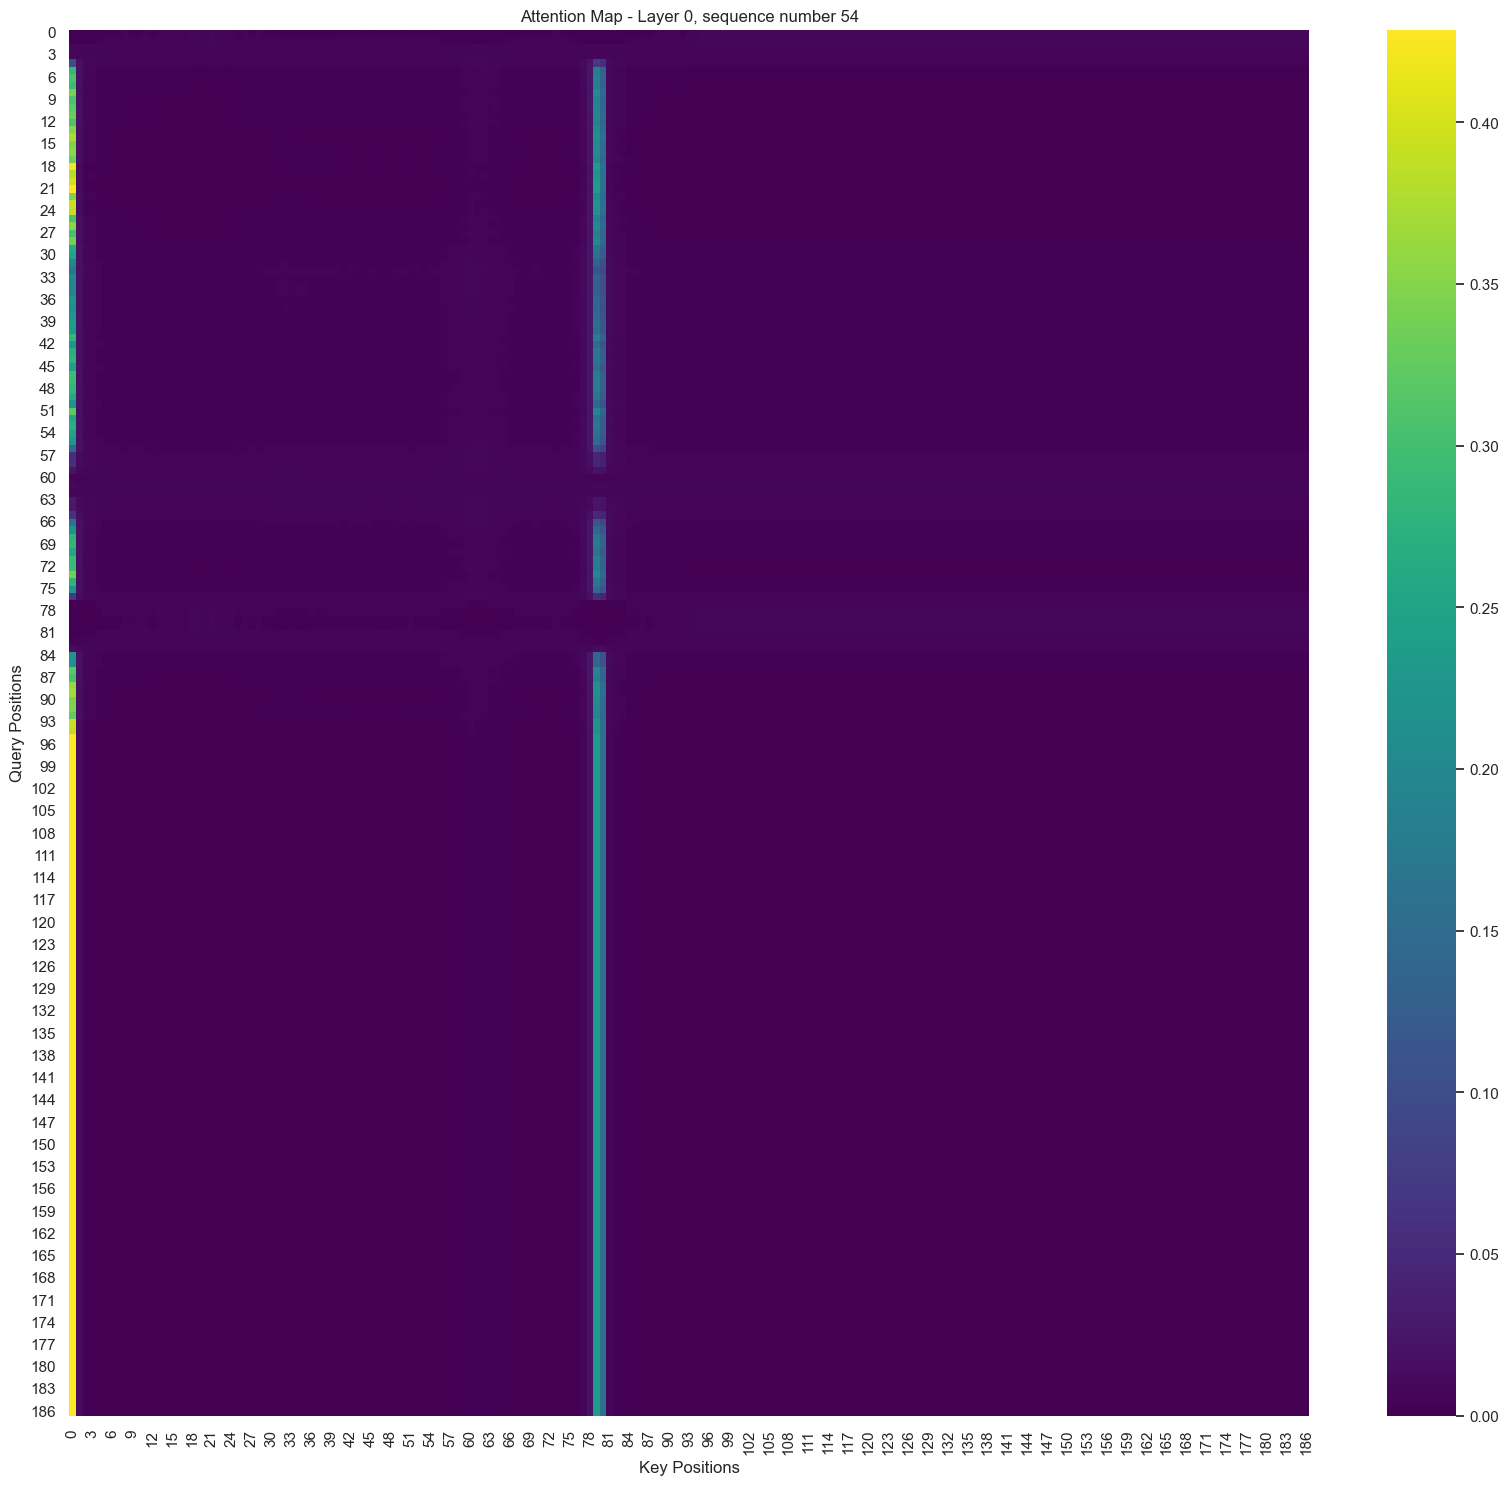

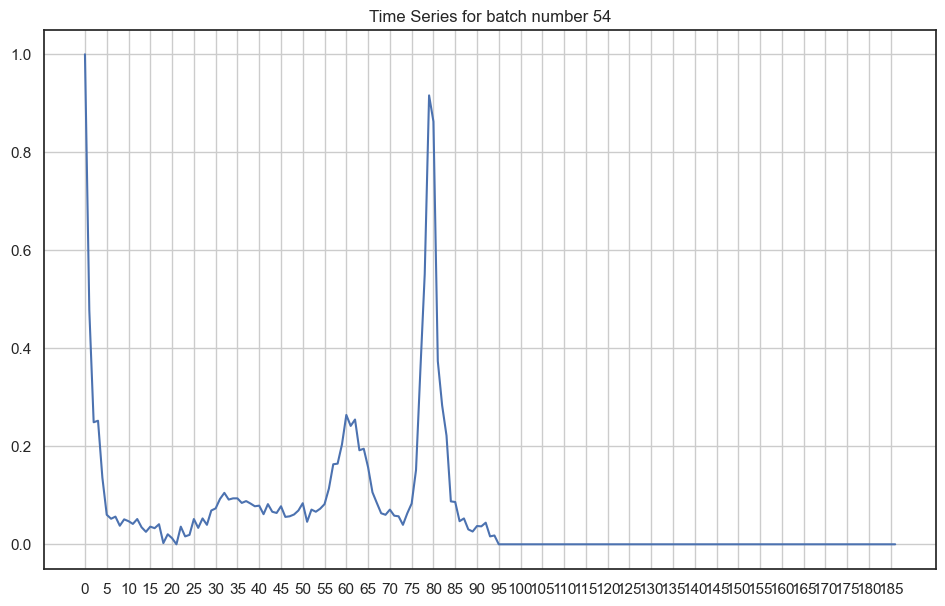

In [20]:
def plot_attention_map(attention_map, layer_num, within_batch_num, plot_time_series = False):
    
    sns.set(style='white')
    plt.figure(figsize=(20,18))
    sns.heatmap(attention_map, cmap='viridis', cbar=True)
    plt.title(f'Attention Map - Layer {layer_num}, sequence number {within_batch_num}')
    plt.xlabel('Key Positions')
    plt.ylabel('Query Positions')


    plt.show()

attention_maps = model.get_attention_maps()
print("shape of attention maps for each layer:", list(attention_maps[0].shape))
layer_num = 0  # First layer
within_batch_num = 54  # CHANGE THIS TO PLOT A DIFFERENT SERIES OF THE TEST SET
attention_map = attention_maps[layer_num][within_batch_num].detach().cpu().numpy()

plot_attention_map(attention_map, layer_num, within_batch_num)

#plot the time sereis for the batch_num
#change size of the plot
plt.figure(figsize=(11.5, 7))
plt.plot(X_test.iloc[within_batch_num, :])
plt.title(f"Time Series for batch number {within_batch_num}")
#add more ticks on x axis
plt.xticks(np.arange(0, 187, 5))
#add grid
plt.grid()
plt.show()